In [1]:
import pandas as pd
import os
import glob
from cuml import TSNE, UMAP
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE as sklearn_tsne
from statannotations.Annotator import Annotator
from scipy.stats import mannwhitneyu

from sklearn.preprocessing import StandardScaler
home = '/home/tpjoe/tpjoe@stanford.edu/project_exosome/'

In [2]:
# load groundtruth
gt = pd.read_excel(os.path.join(home,'data','TPAD_CSF EV samples_koya.xlsx'))
gt = gt.loc[:, ['TPAD ID', 'Linkcode', 'Cohort', 'Diagnosis', 'PID 1-90']]
gt['PID 1-90'] = gt['PID 1-90'].astype('str')
gt.head(3)

TPAD ID Linkcode  Cohort Diagnosis PID 1-90
0  TPAD0473   141236  Poston        HC        1
1  TPAD0450   141091  Poston        HC        2
2  TPAD0494   141370  Poston        HC        3

In [3]:
# # load data
# dico_panel2marker = {1:"A-Beta", 2:"Tau-5", 3:"A-Syn",4:"ApoE"}
# df_tot = []
# panel_id = 1
# for panel_id in [1,2,3,4]:
#     print(panel_id)
#     panel_dir = os.path.join(home,'data','Cohort Runs',"Panel %s"%str(panel_id), 'Panel %s - Single-Particle data'%(str(panel_id)))
#     file_list = [i for i in glob.glob(panel_dir+ "/Run */*") if '001_TotalParticles-' in i]
#     file_list.sort()
#     data_dict = {str(i+1)+'_'+str(k):v for i,d in enumerate([pd.read_excel(os.path.join(panel_dir, filename), sheet_name=None, header=None) for filename in file_list]) for k,v in d.items()}
#     data_dict = {i:data_dict[i] for i in data_dict.keys() if all([j not in i for j in ['Parameters', 'Subpopulations']])}

#     # join data into a dataframe
#     data_list = []

#     for person in data_dict.keys():
#         data_sample = [data_dict[person].iloc[:, i*5:(i*5+5)].transpose().reset_index(drop=True).transpose() for i in range(int(data_dict[person].shape[1]/5))]
#         data_sample = [d.iloc[1:, :] for d in data_sample]
#         data_sample = [d[~d.isna().all(axis=1)] for d in data_sample]

#         for i in range(len(data_sample)):
#             data_sample[i].loc[:,5] = data_sample[i].iloc[0,1]
#             data_sample[i].loc[:,0] = data_sample[i].loc[:,0].fillna(method="ffill")
#             data_sample[i].columns = ['spot'] + data_sample[i].iloc[1,1:5].tolist() + ['marker']
#             data_sample[i] = data_sample[i].iloc[2:,:]

#         data_df = pd.concat(data_sample, axis=0)
#         #filter by size
#         data_exo = data_df.loc[(data_df.IM>=50) & (data_df.IM<=200), :].reset_index(drop=True)
#         data_exo.loc[:, 'samples'] = person
#         data_list += [data_exo]

#     df = pd.concat(data_list, axis=0).reset_index(drop=True)
#     df[['batch', 'samples']] = df.samples.str.split('_', expand=True)
#     df["panel"] = panel_id

#     df_tot.append(df)

# df = pd.concat(df_tot)
# df[['CD47','PrP','IM', "Tau-5", "A-Syn", "ApoE"]] = df.loc[:, ['CD47','PrP','IM', "Tau-5", "A-Syn", "ApoE"]].astype('float')

In [4]:
df = pd.read_csv(home + "data/Cohort Runs/whole_dataset.csv", index_col=None, low_memory=False)

In [5]:
# merge with gt
df = df.merge(gt, left_on='samples', right_on='PID 1-90', how='left')
df[["PID 1-90", "samples"]] = df[["PID 1-90", "samples"]].astype('str')

In [6]:
df.head(3)

spot  A-Beta  CD47    PrP         IM marker samples  batch  panel  Tau-5  \
0  Spot4     0.0   0.0    0.0  50.350120   CD63       9      1      1    NaN   
1  Spot4     0.0   0.0  624.0  50.389418   CD63       9      1      1    NaN   
2  Spot4     0.0   0.0    0.0  50.520433   CD63       9      1      1    NaN   

   A-Syn  ApoE   TPAD ID Linkcode  Cohort Diagnosis PID 1-90  
0    NaN   NaN  TPAD0491   141362  Poston        HC        9  
1    NaN   NaN  TPAD0491   141362  Poston        HC        9  
2    NaN   NaN  TPAD0491   141362  Poston        HC        9

In [14]:
df.marker.unique()

array(['CD63', 'CD81', 'CD9', 'MIgG'], dtype=object)

x          y   spot  A-Beta  CD47    PrP         IM marker  \
0      36.381004 -30.264585  Spot1     0.0   0.0    0.0  53.737183   CD81   
1       2.784455  25.443455  Spot2     0.0   0.0    0.0  56.444350   CD81   
2       3.101114 -24.540688  Spot2     0.0   0.0    0.0  52.171281   CD81   
3     -10.278683  30.075262  Spot3     0.0   0.0    0.0  62.584685   CD81   
4      31.869099  46.376354  Spot9     0.0   0.0    0.0  57.326790    CD9   
...          ...        ...    ...     ...   ...    ...        ...    ...   
17995 -35.452324  20.966068  Spot9     0.0   0.0    0.0  51.350403    CD9   
17996 -26.207529 -23.165348  Spot1     0.0   0.0  748.0  54.589706   CD81   
17997 -32.612480 -20.538094  Spot7     0.0   0.0  857.0  53.485369    CD9   
17998 -24.786261 -32.266006  Spot1     0.0   0.0  656.0  53.017577   CD81   
17999 -18.240437  -5.400375  Spot9     0.0   0.0  661.0  62.550110    CD9   

      samples  batch  panel  Tau-5  A-Syn  ApoE   TPAD ID Linkcode    Cohort  \
0          23      1      1    NaN    NaN   NaN  TPAD0340     1148      ADRC   
1          41      1      1    NaN    NaN   NaN  TPAD0378     1237      ADRC   
2           3      1      1    NaN    NaN   NaN  TPAD0494   141370    Poston   
3          39      1      1    NaN    NaN   NaN  TPAD0361     1205      ADRC   
4          41      1      1    NaN    NaN   NaN  TPAD0378     1237      ADRC   
...       ...    ...    ...    ...    ...   ...       ...      ...       ...   
17995      40      6      1    NaN    NaN   NaN  TPAD0377     1236      ADRC   
17996      81      6      1    NaN    NaN   NaN  TPAD0454   141130    Poston   
17997      67      6      1    NaN    NaN   NaN  TPAD0452   141112    Poston   
17998      57      6      1    NaN    NaN   NaN  TPAD0325     1091      ADRC   
17999      54      6      1    NaN    NaN   NaN  TPAD0444   141064  Kerchner   

      Diagnosis PID 1-90  
0            HC       23  
1            AD       41  
2            HC        3  
3            AD       39  
4            AD       41  
...         ...      ...  
17995        AD       40  
17996        PD       81  
17997        PD       67  
17998       MCI       57  
17999       MCI       54  

[18000 rows x 19 columns]

/home/tpjoe/miniconda3/envs/rapids/lib/python3.9/site-packages/cuml/internals/api_decorators.py:794: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


[W] [21:32:15.849033] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


/home/tpjoe/miniconda3/envs/rapids/lib/python3.9/site-packages/cuml/internals/api_decorators.py:794: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


[W] [21:32:26.510502] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


/home/tpjoe/miniconda3/envs/rapids/lib/python3.9/site-packages/cuml/internals/api_decorators.py:794: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


[W] [21:32:36.681002] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


/home/tpjoe/miniconda3/envs/rapids/lib/python3.9/site-packages/cuml/internals/api_decorators.py:794: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


[W] [21:32:46.925388] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


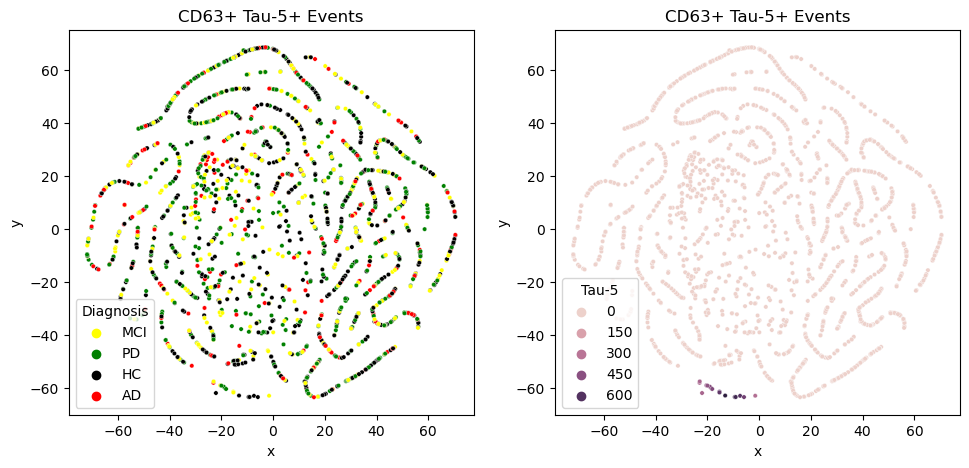

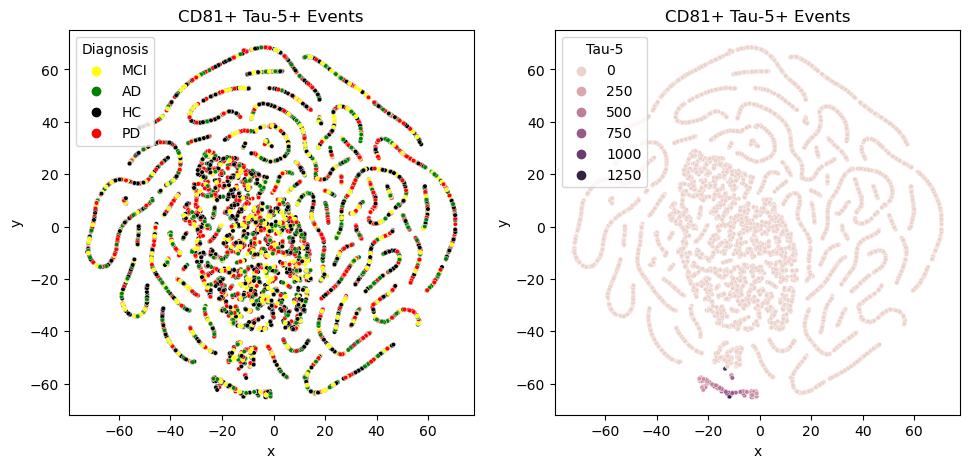

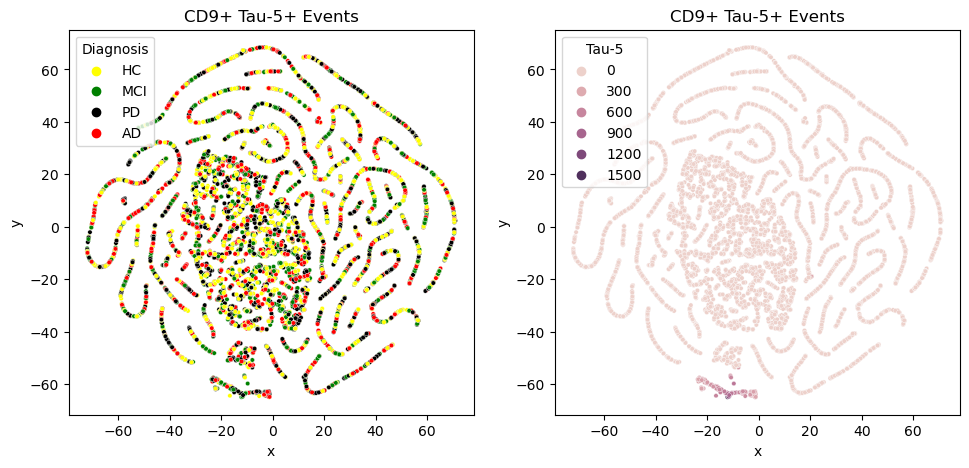

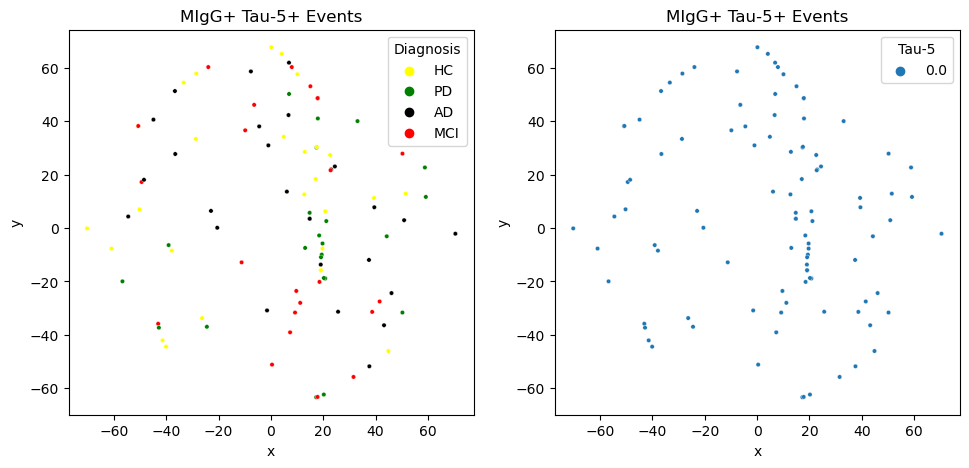

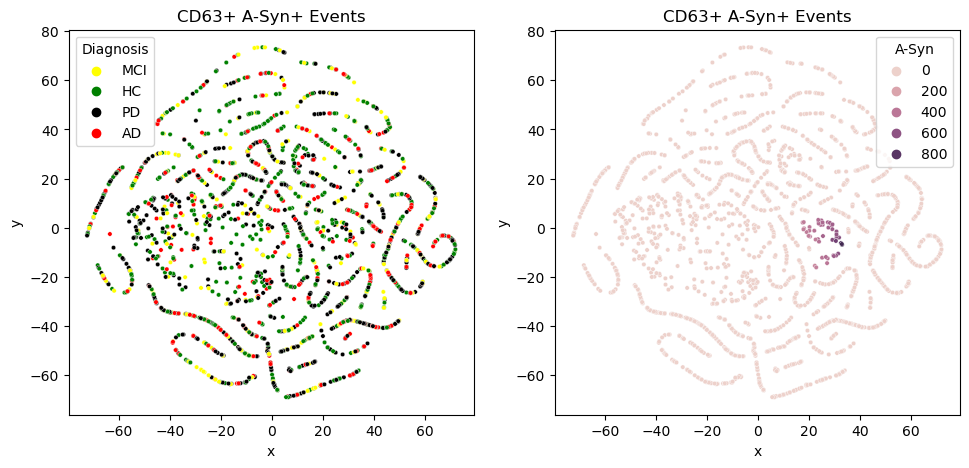

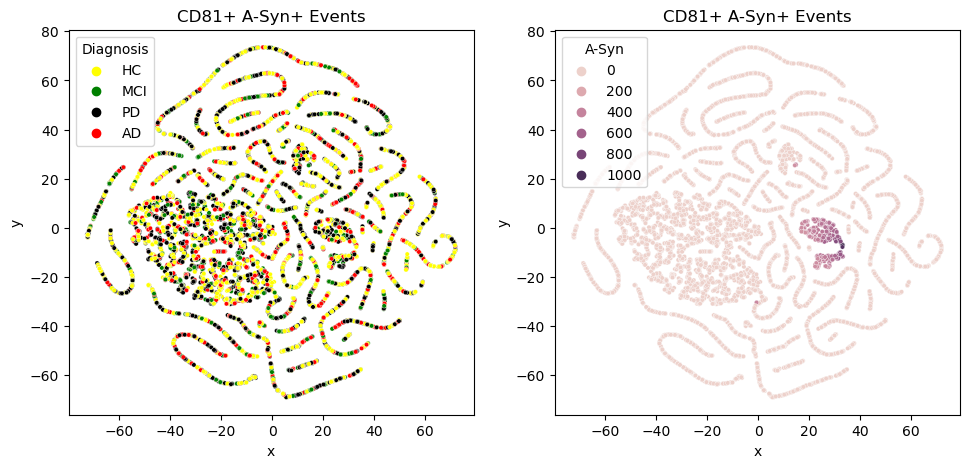

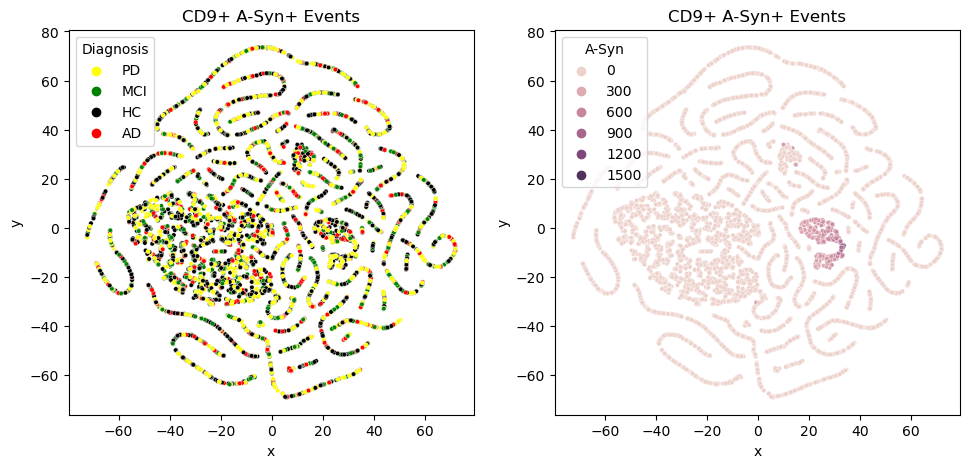

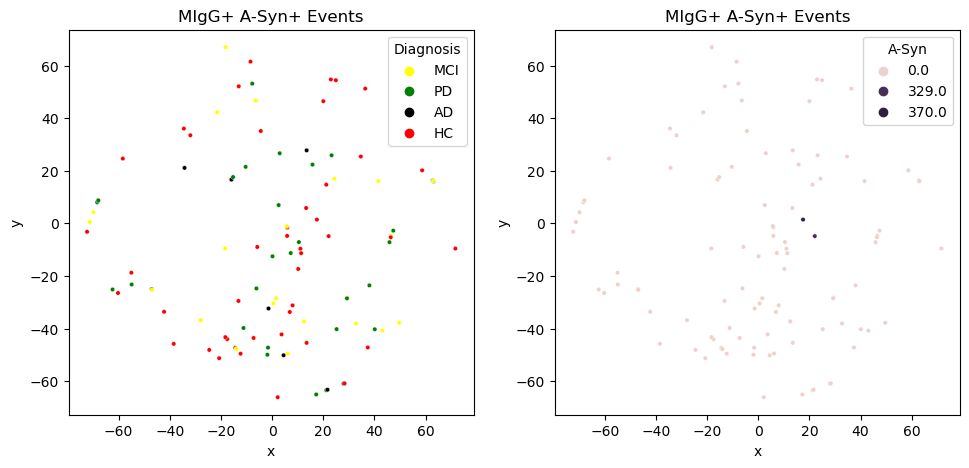

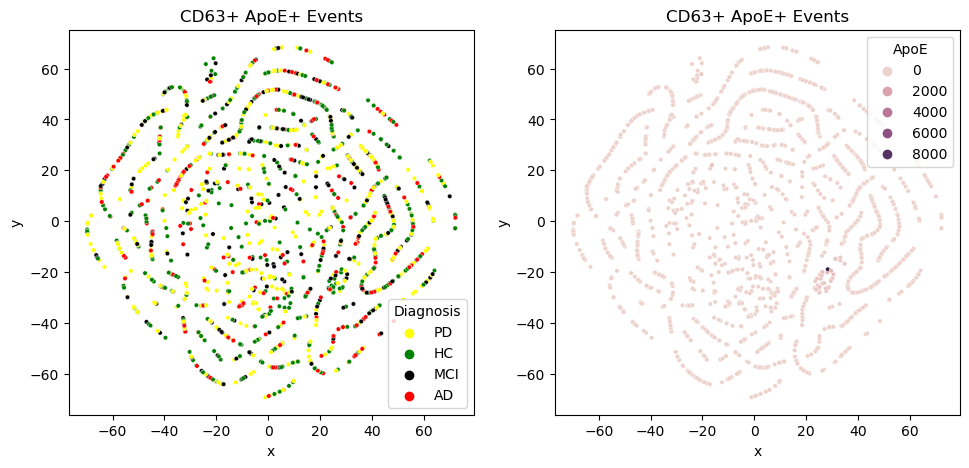

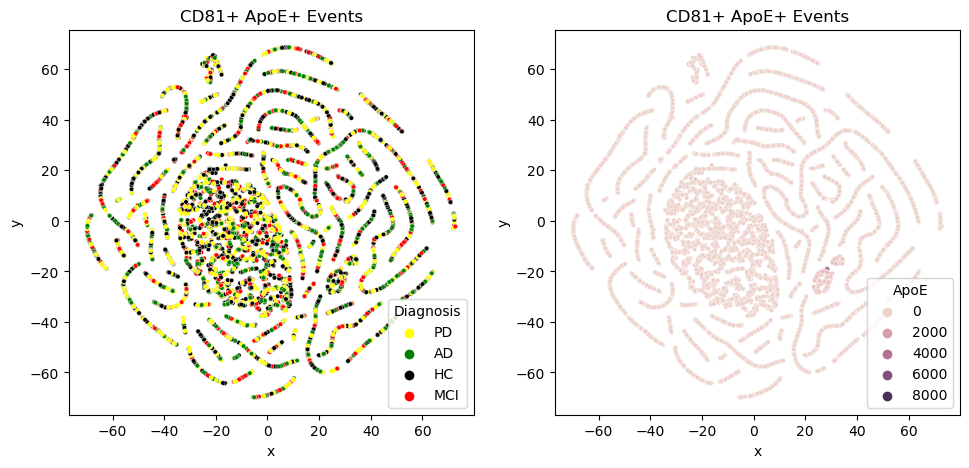

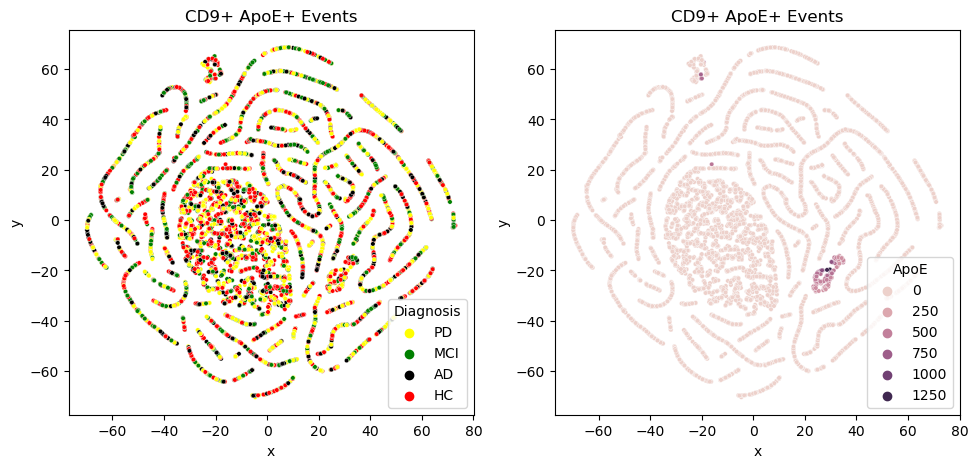

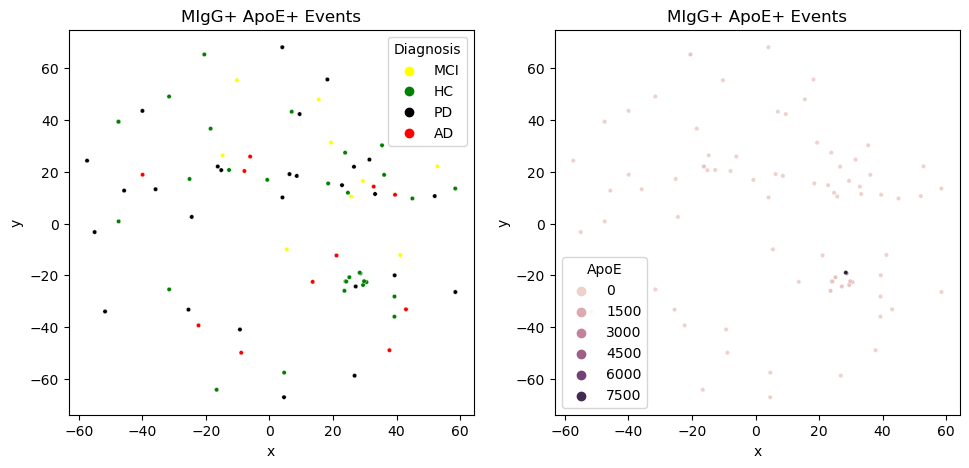

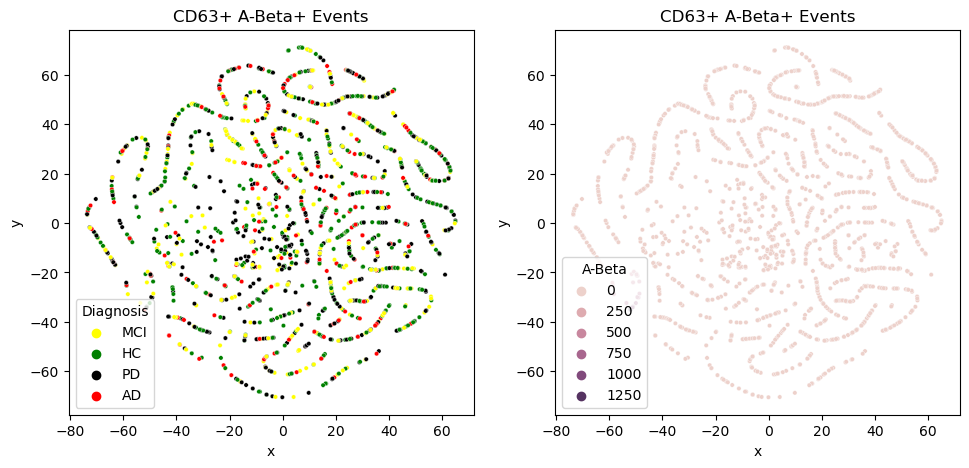

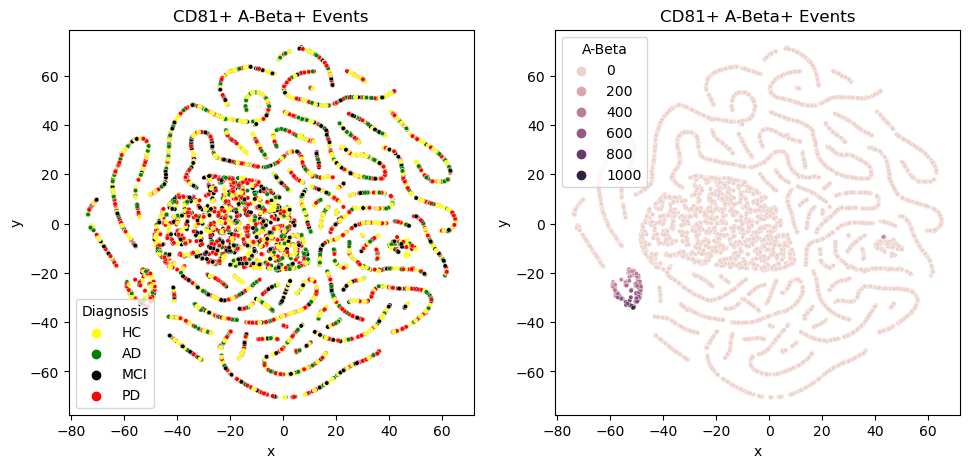

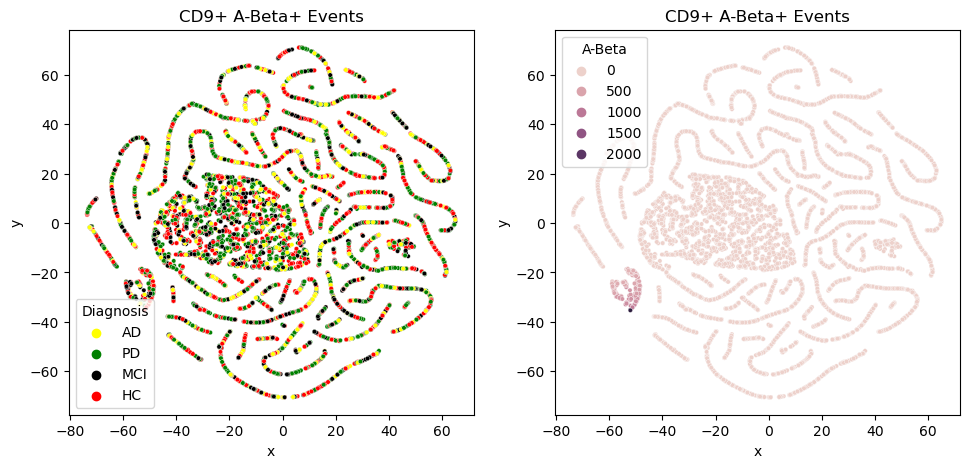

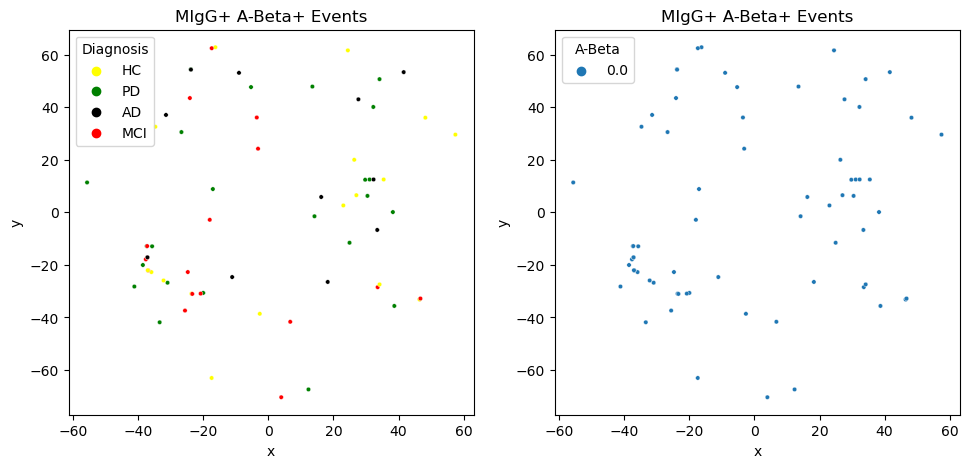

In [29]:
# protein = 'A-Beta'  #<<<<<<<<<<<<<<<<<<<< SET PROTEIN OF CHOICE HERE FROM 'Tau5', 'A-Syn', 'ApoE', 'A-Beta'
# marker = ['CD81']  #<<<<<<<<<<<<<<<<<<<< YOU CAN SET ANYTHING/NUMBER from 'CD63', 'CD81', 'CD9', 'MIgG'

for protein in ['Tau-5', 'A-Syn', 'ApoE', 'A-Beta']:
    df_sub = pd.concat([df.loc[(df.batch==i) & (~df[protein].isna()) & (~df['Diagnosis'].isna())].sample(n=3000, random_state=1) for i in df.batch.unique()], axis=0)
    reducer = TSNE(perplexity=30)#(n_components=2, perplexity=10.0, n_jobs=-1, learning_rate='auto')   <--------------- USE "sklearn_tsne" instead of "TNSE" if you don't have GPU and cuml installed
    xy_coor = pd.DataFrame(reducer.fit_transform(StandardScaler().fit_transform(df_sub.loc[:, [protein, 'CD47', 'PrP', 'IM']])), columns=['x', 'y'])
    for marker in ['CD63', 'CD81', 'CD9', 'MIgG']:
        fig, axs = plt.subplots(1, 2, figsize=(11.5,5))
        df_plt = pd.concat([xy_coor, df_sub.reset_index(drop=True)], axis=1)
        df_plt = df_plt.loc[df_plt.marker.isin([marker]), :]
        df_plt['Diagnosis'] = df_plt['Diagnosis'].apply(lambda x: 'PD' if 'PD' in x else x)
        # sns.scatterplot(data=df_plt, x='x', y='y', s=10, hue='marker', alpha=1, ax=axs[0])
        sns.scatterplot(data=df_plt, x='x', y='y', s=10, hue='Diagnosis', alpha=1, ax=axs[0], palette=['yellow', 'green', 'black', 'red'])
        sns.scatterplot(data=df_plt, x='x', y='y', s=10, hue=protein, alpha=1, ax=axs[1])
        axs[0].set_title(marker+'+ '+protein+'+ Events')
        axs[1].set_title(marker+'+ '+protein+'+ Events')
        plt.savefig('../figures/TSNE_'+marker+'_'+protein+'.png', dpi=600)
        # axs[2].title('Tau5+ Events')

# Unused

In [30]:
protein = 'Tau-5'
marker = 'CD81'
test_df = df.loc[(df['marker']==marker) & (~df[protein].isna()) & (~df['Diagnosis'].isna())]
test_df_nonzero = test_df.loc[test_df[protein]!=0]
test_df.head(2)

spot  A-Beta  CD47    PrP         IM marker samples  batch  panel  \
1527054  Spot1     NaN   0.0  577.0  56.505901   CD81       8      1      2   
1527055  Spot1     NaN   0.0    0.0  50.078818   CD81       8      1      2   

         Tau-5  A-Syn  ApoE   TPAD ID Linkcode  Cohort Diagnosis PID 1-90  
1527054    0.0    NaN   NaN  TPAD0486   141346  Poston        HC        8  
1527055    0.0    NaN   NaN  TPAD0486   141346  Poston        HC        8

In [39]:
percent_nonzero = pd.DataFrame((test_df_nonzero.groupby('samples').count().iloc[:, 0]/test_df.groupby('samples').count().iloc[:, 0])*100).reset_index()
percent_nonzero['Diagnosis'] = percent_nonzero.samples.apply(lambda x: test_df.loc[test_df.samples==x, 'Diagnosis'].unique()[0])
percent_nonzero.columns = ['samples', 'percent', 'Diagnosis']

<AxesSubplot:xlabel='Diagnosis', ylabel='percent'>

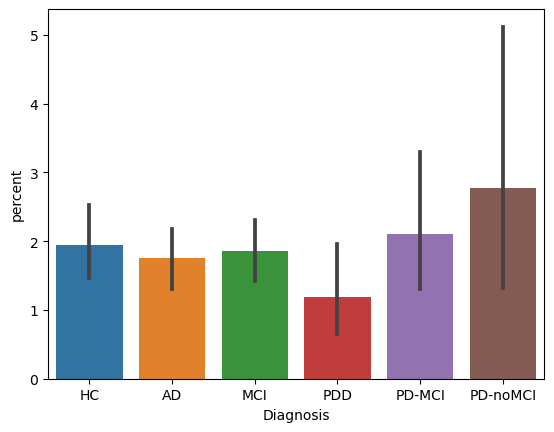

In [41]:
sns.barplot(data=percent_nonzero, x='Diagnosis', y='percent')

In [40]:
# distribution plots by batch and by groups
marker = ['A-Beta', 'CD47', 'PrP']
df_plt = (df.groupby(['Diagnosis', 'samples'])[marker].apply(lambda x: (x>0).sum())/df.groupby(['Diagnosis', 'samples']).count().loc[:, marker]*100).reset_index()
df_plt = df_plt.melt(['Diagnosis', 'samples'])
df_plt.head(3)

samples    percent Diagnosis
0        1   2.475006        HC
1       10   2.245004        HC
2       11   0.573751        HC
3       12   7.366227        HC
4       13   1.245988        HC
..     ...        ...       ...
72      87   1.620792  PD-noMCI
73      88  14.048626  PD-noMCI
74      89   2.990685  PD-noMCI
75       9   0.670430        HC
76      90   1.947894  PD-noMCI

[77 rows x 3 columns]

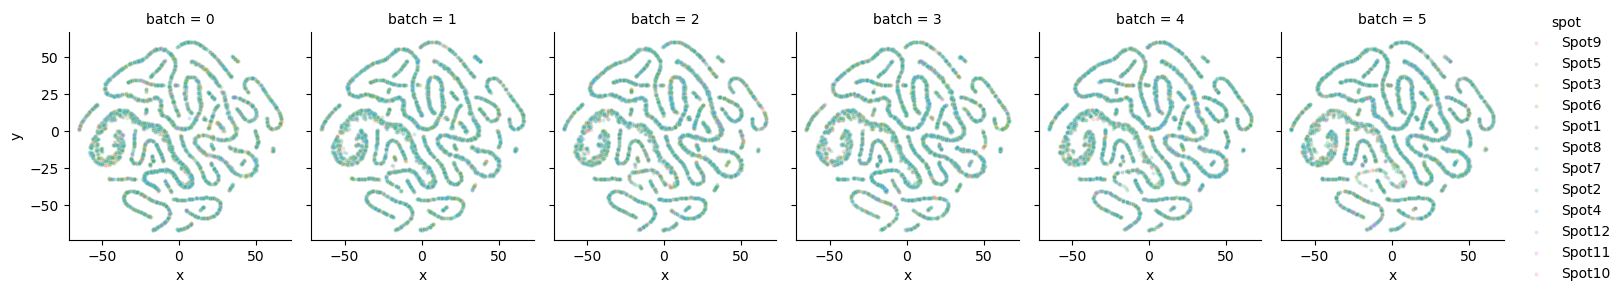

In [167]:
# fig, ax = plt.subplots(1, figsize=(10, 5))
g = sns.FacetGrid(df_plt, col="batch", aspect=0.85, hue='spot')
g.map(sns.scatterplot, "x", "y", s=8, alpha=0.25)
g.add_legend()

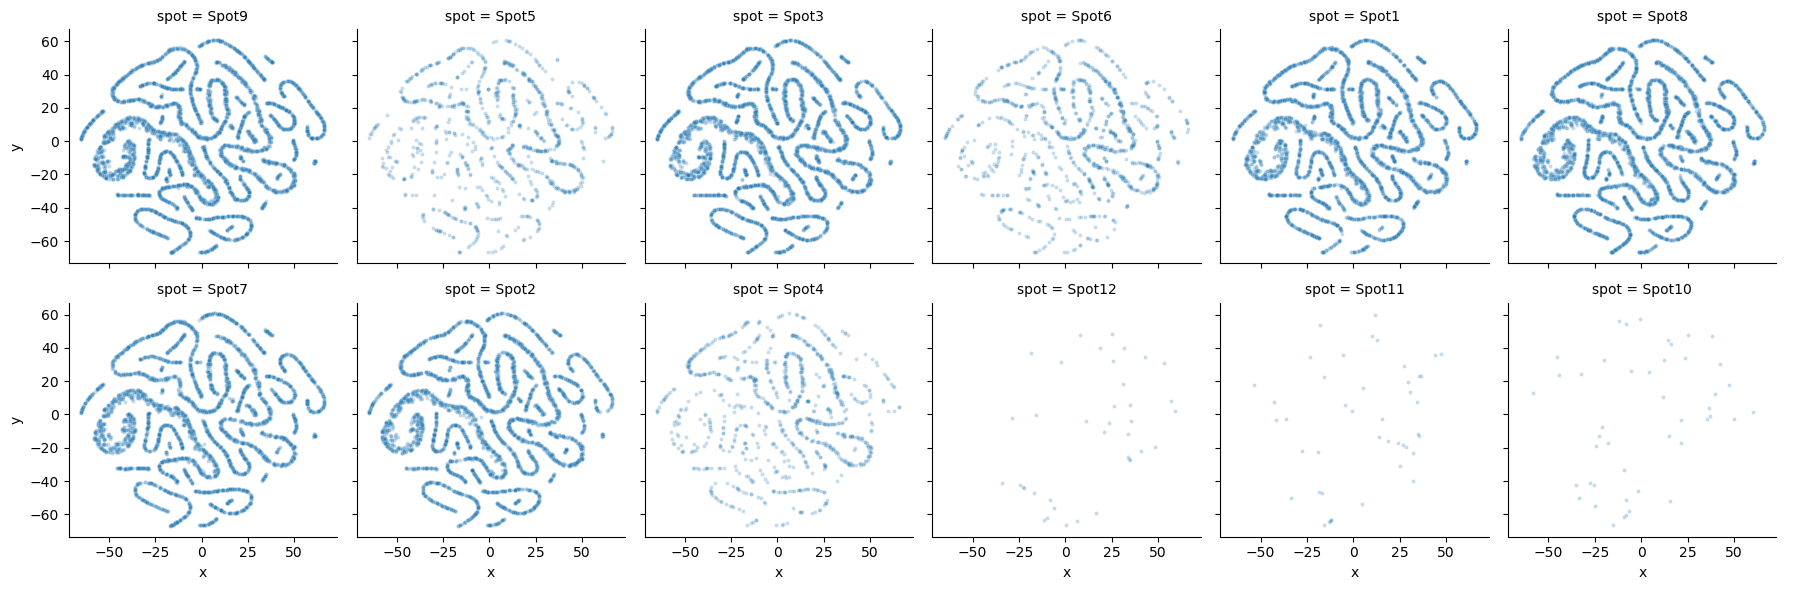

In [178]:
# fig, ax = plt.subplots(1, figsize=(10, 5))
g = sns.FacetGrid(df_plt, col="spot", aspect=1, col_wrap=6)
g.map(sns.scatterplot, "x", "y", s=8, alpha=0.25)
g.add_legend()

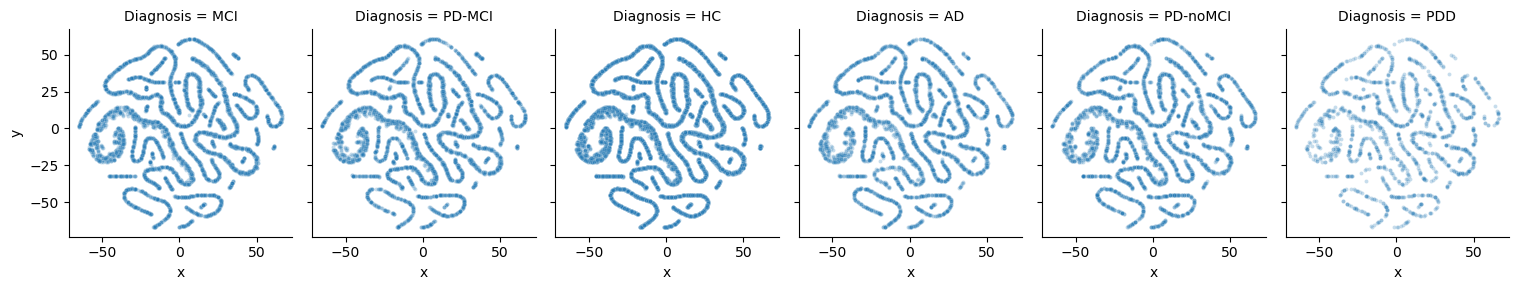

In [169]:
# fig, ax = plt.subplots(1, figsize=(10, 5))
g = sns.FacetGrid(df_plt, col="Diagnosis", aspect=0.85)
g.map(sns.scatterplot, "x", "y", s=8, alpha=0.25)
g.add_legend()

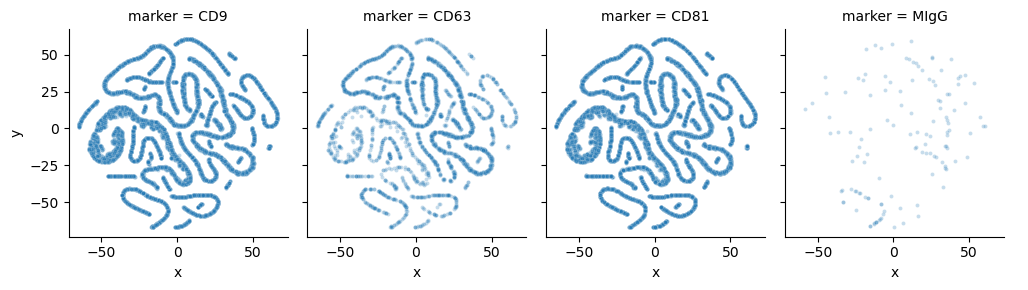

In [170]:
# fig, ax = plt.subplots(1, figsize=(10, 5))
g = sns.FacetGrid(df_plt, col="marker", aspect=0.85)
g.map(sns.scatterplot, "x", "y", s=8, alpha=0.25)
g.add_legend()

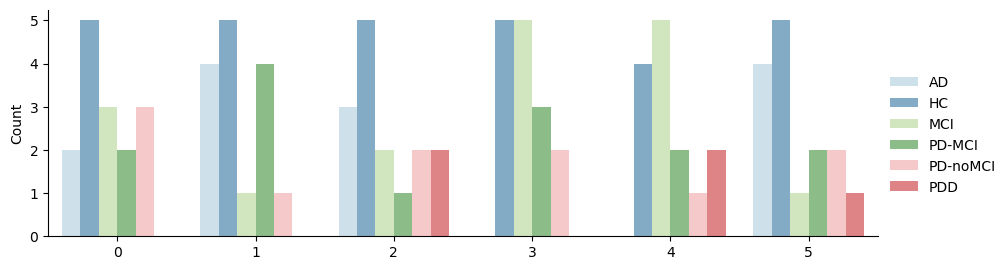

In [229]:
# classes in each batch
df_plt = df.drop_duplicates('samples').groupby(['batch', 'Diagnosis']).count().iloc[:, 0].reset_index()
g = sns.catplot(
    data=df_plt, kind="bar",
    x="batch", y="spot", hue="Diagnosis",
    palette="Paired", alpha=.6, height=3, aspect=3
)
# g.despine(left=True)
g.set_axis_labels("", "Count")
g.legend.set_title("")

In [244]:
# distribution plots by batch and by groups
marker = ['A-Beta', 'CD47', 'PrP']
df_plt = (df.groupby(['batch', 'samples'])[marker].apply(lambda x: (x>0).sum())/df.groupby(['batch', 'samples']).count().loc[:, marker]*100).reset_index()
df_plt = df_plt.melt(['batch', 'samples'])
df_plt.head(3)

batch samples variable     value
0     0      14   A-Beta  0.580416
1     0      16   A-Beta  0.297991
2     0      20   A-Beta  0.719175

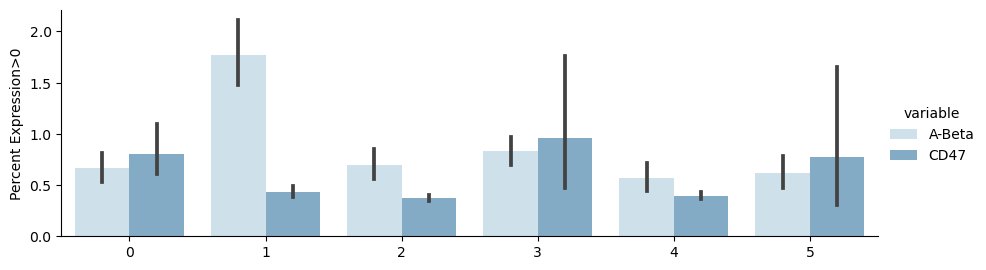

In [247]:
g = sns.catplot(
    data=df_plt.loc[df_plt.variable!='PrP', :], kind="bar",
    x="batch", y="value", hue="variable",
    palette="Paired", alpha=.6, height=3, aspect=3
)
# g.despine(left=True)
g.set_axis_labels("", "Percent Expression>0")
# g.legend.set_title("")

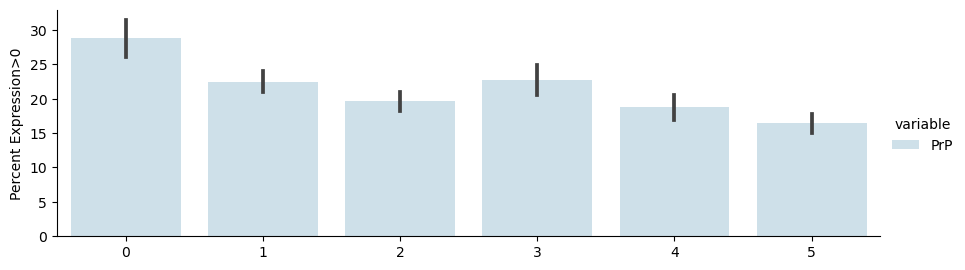

In [248]:
g = sns.catplot(
    data=df_plt.loc[df_plt.variable=='PrP', :], kind="bar",
    x="batch", y="value", hue="variable",
    palette="Paired", alpha=.6, height=3, aspect=3
)
# g.despine(left=True)
g.set_axis_labels("", "Percent Expression>0")
# g.legend.set_title("")

In [42]:
# distribution plots by batch and by groups
marker = ['A-Beta', 'CD47', 'PrP']
df_plt = (df.groupby(['Diagnosis', 'samples'])[marker].apply(lambda x: (x>0).sum())/df.groupby(['Diagnosis', 'samples']).count().loc[:, marker]*100).reset_index()
df_plt = df_plt.melt(['Diagnosis', 'samples'])
df_plt.head(3)

Diagnosis samples variable     value
0        AD      31   A-Beta  2.133092
1        AD      32   A-Beta  1.372074
2        AD      33   A-Beta  2.434916

NameError: name 'ax' is not defined

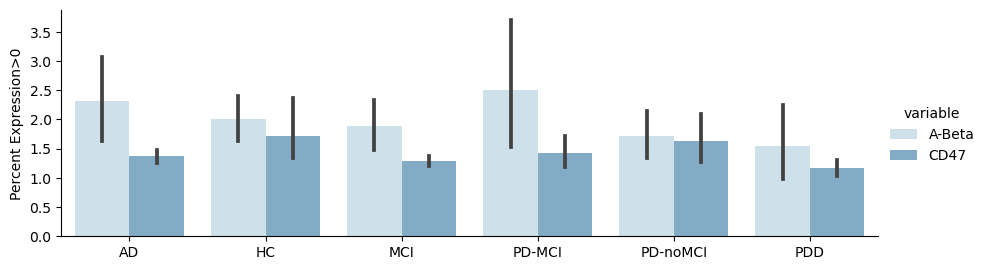

In [43]:
g = sns.catplot(
    data=df_plt.loc[df_plt.variable!='PrP', :], kind="bar",
    x="Diagnosis", y="value", hue="variable",
    palette="Paired", alpha=.6, height=3, aspect=3
)
# g.despine(left=True)
g.set_axis_labels("", "Percent Expression>0")
# g.legend.set_title("")

pairs = [[('AD', 'CD47'), ('PD-MCI', 'CD47')], [('AD', 'A-Beta'), ('PDD', 'A-Beta')]] #[[(i, "A-Bata"), (i, "A-Bata")] for i in df_plt.Diagnosis.unique()]
annotator = Annotator(ax, pairs, data=df_plt, x='Diagnosis', y='value', hue='variable')
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', comparisons_correction="bonferroni")
annotator.apply_and_annotate()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

AD_CD47 vs. PD-MCI_CD47: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:3.641e-01 U_stat=6.300e+01
AD_A-Beta vs. PDD_A-Beta: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=4.000e+01


(<AxesSubplot:>,
  <statannotations.Annotation.Annotation at 0x7fdc70bb78b0>])

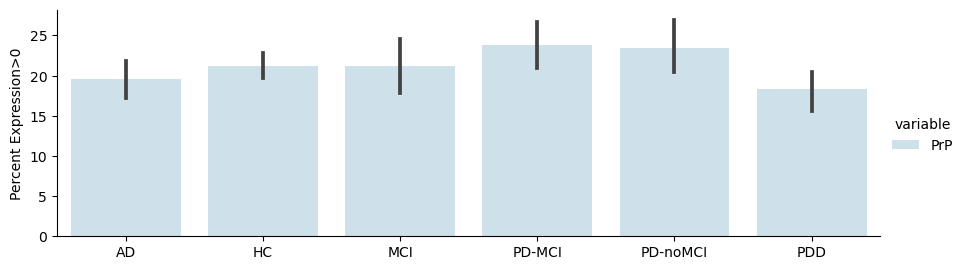

In [262]:
g = sns.catplot(
    data=df_plt.loc[df_plt.variable=='PrP', :], kind="bar",
    x="Diagnosis", y="value", hue="variable",
    palette="Paired", alpha=.6, height=3, aspect=3
)
# g.despine(left=True)
g.set_axis_labels("", "Percent Expression>0")
# g.legend.set_title("")

pairs = [[('AD', 'CD47'), ('PD-MCI', 'CD47')], [('AD', 'A-Beta'), ('PDD', 'A-Beta')]] #[[(i, "A-Bata"), (i, "A-Bata")] for i in df_plt.Diagnosis.unique()]
annotator = Annotator(ax, pairs, data=df_plt, x='Diagnosis', y='value', hue='variable')
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', comparisons_correction="bonferroni")
annotator.apply_and_annotate()

In [261]:
mannwhitneyu(df_plt.loc[(df_plt.Diagnosis=='AD') & (df_plt.variable=='CD47'), 'value'], df_plt.loc[(df_plt.Diagnosis=='PD-MCI') & (df_plt.variable=='CD47'), 'value'])

MannwhitneyuResult(statistic=63.0, pvalue=0.1820500814244328)

In [282]:
# distribution plots by batch and by groups
marker = ['A-Beta', 'CD47', 'PrP']
df_plt = (df.groupby(['Diagnosis', 'samples'])[marker].apply(lambda x: x[(x>0)].mean())).reset_index()
df_plt = df_plt.melt(['Diagnosis', 'samples'])
df_plt.head(3)

Diagnosis samples variable       value
0        AD      31   A-Beta  675.906250
1        AD      32   A-Beta  654.272727
2        AD      33   A-Beta  663.757576

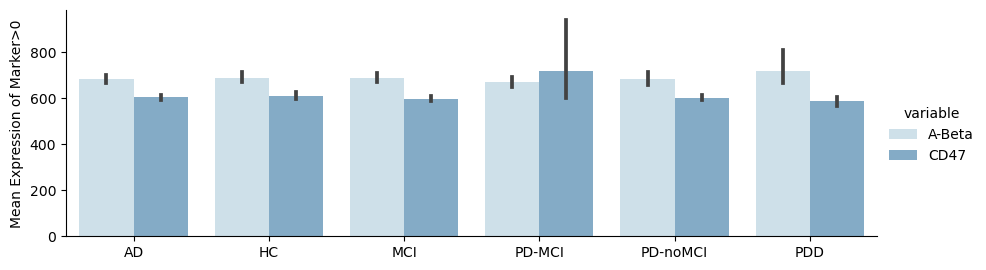

In [ ]:
g = sns.catplot(
    data=df_plt.loc[df_plt.variable!='PrP', :], kind="bar",
    x="Diagnosis", y="value", hue="variable",
    palette="Paired", alpha=.6, height=3, aspect=3
)
# g.despine(left=True)
g.set_axis_labels("", "Mean Expression of Marker>0")
# g.legend.set_title("")

# pairs = [[('AD', 'CD47'), ('PD-MCI', 'CD47')], [('AD', 'A-Beta'), ('PDD', 'A-Beta')]] #[[(i, "A-Bata"), (i, "A-Bata")] for i in df_plt.Diagnosis.unique()]
# annotator = Annotator(ax, pairs, data=df_plt, x='Diagnosis', y='value', hue='variable')
# annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', comparisons_correction="bonferroni")
# annotator.apply_and_annotate()

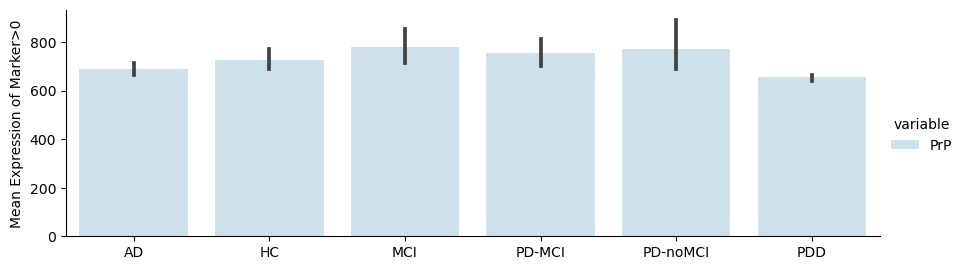

In [286]:
g = sns.catplot(
    data=df_plt.loc[df_plt.variable=='PrP', :], kind="bar",
    x="Diagnosis", y="value", hue="variable",
    palette="Paired", alpha=.6, height=3, aspect=3
)
# g.despine(left=True)
g.set_axis_labels("", "Mean Expression of Marker>0")
# g.legend.set_title("")

# pairs = [[('AD', 'CD47'), ('PD-MCI', 'CD47')], [('AD', 'A-Beta'), ('PDD', 'A-Beta')]] #[[(i, "A-Bata"), (i, "A-Bata")] for i in df_plt.Diagnosis.unique()]
# annotator = Annotator(ax, pairs, data=df_plt, x='Diagnosis', y='value', hue='variable')
# annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', comparisons_correction="bonferroni")
# annotator.apply_and_annotate()

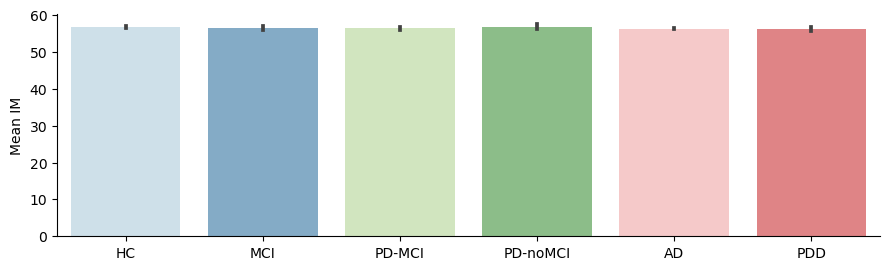

In [297]:
g = sns.catplot(
    data=pd.concat([df[['samples', 'Diagnosis']].drop_duplicates().set_index('samples'), df.groupby('samples').mean()], axis=1), 
    kind="bar",
    x="Diagnosis", y="IM",
    palette="Paired", alpha=.6, height=3, aspect=3
)
# g.despine(left=True)
g.set_axis_labels("", "Mean IM")
# g.legend.set_title("")

In [308]:
df

spot  A-Beta  CD47  PrP         IM marker samples batch   TPAD ID  \
0         Spot4     0.0   0.0  0.0  53.497864   CD63      14     0  TPAD0470   
1         Spot4     0.0   0.0  0.0  55.683592   CD63      14     0  TPAD0470   
2         Spot4     0.0   0.0  0.0  54.707117   CD63      14     0  TPAD0470   
3         Spot4     0.0   0.0  0.0  55.295506   CD63      14     0  TPAD0470   
4         Spot4     0.0   0.0  0.0  94.367331   CD63      14     0  TPAD0470   
...         ...     ...   ...  ...        ...    ...     ...   ...       ...   
1560055  Spot12     0.0   0.0  0.0  75.261573   MIgG      77     5  TPAD0446   
1560056  Spot12     0.0   0.0  0.0  56.187997   MIgG      77     5  TPAD0446   
1560057  Spot12     0.0   0.0  0.0  55.049512   MIgG      77     5  TPAD0446   
1560058  Spot12     0.0   0.0  0.0  56.437910   MIgG      77     5  TPAD0446   
1560059  Spot12     0.0   0.0  0.0  50.911704   MIgG      77     5  TPAD0446   

        Linkcode    Cohort Diagnosis PID 1-90  
0         141222  Kerchner        HC       14  
1         141222  Kerchner        HC       14  
2         141222  Kerchner        HC       14  
3         141222  Kerchner        HC       14  
4         141222  Kerchner        HC       14  
...          ...       ...       ...      ...  
1560055   141074    Poston    PD-MCI       77  
1560056   141074    Poston    PD-MCI       77  
1560057   141074    Poston    PD-MCI       77  
1560058   141074    Poston    PD-MCI       77  
1560059   141074    Poston    PD-MCI       77  

[1560060 rows x 13 columns]

In [309]:
# number of measurements by spots/batch/groups
df_plt = df.groupby(['batch', 'spot', 'Diagnosis', 'marker']).count().iloc[:, 0].reset_index()
df_plt

batch   spot Diagnosis marker  A-Beta
0       0  Spot1        AD   CD81    3060
1       0  Spot1        HC   CD81   16427
2       0  Spot1       MCI   CD81   11681
3       0  Spot1    PD-MCI   CD81    7009
4       0  Spot1  PD-noMCI   CD81    8079
..    ...    ...       ...    ...     ...
363     5  Spot9        HC    CD9   14778
364     5  Spot9       MCI    CD9    1617
365     5  Spot9    PD-MCI    CD9    4864
366     5  Spot9  PD-noMCI    CD9    7674
367     5  Spot9       PDD    CD9    2056

[368 rows x 5 columns]

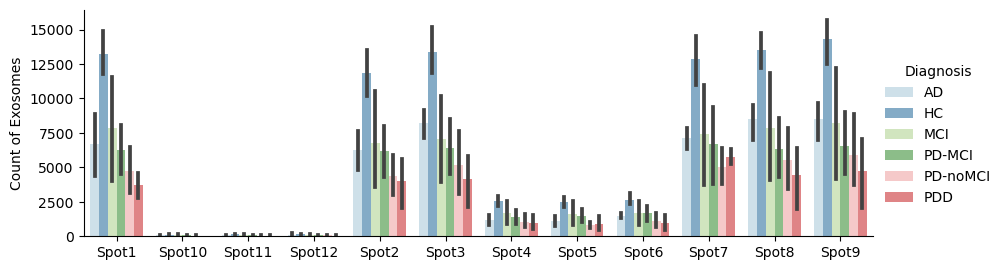

In [307]:
g = sns.catplot(
    data=df_plt, kind="bar",
    x="spot", y="A-Beta", hue="Diagnosis",
    palette="Paired", alpha=.6, height=3, aspect=3
)
# g.despine(left=True)
g.set_axis_labels("", "Count of Exosomes")
# g.legend.set_title("")

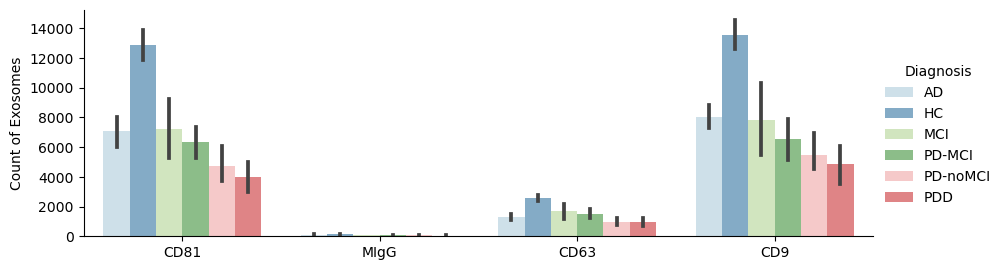

In [311]:
g = sns.catplot(
    data=df_plt, kind="bar",
    x="marker", y="A-Beta", hue="Diagnosis",
    palette="Paired", alpha=.6, height=3, aspect=3
)
# g.despine(left=True)
g.set_axis_labels("", "Count of Exosomes")
# g.legend.set_title("")